In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import pandas as pd
import numpy as np

## 0. Set Spotify API Credentials

```python
os.environ["SPOTIPY_CLIENT_ID"] = "your client ID"
os.environ["SPOTIPY_CLIENT_SECRET"] = "your client secret"
```

Client ID and secret can be obtained by creating a task in "Spotify for Developers".

In [51]:
auth = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager = auth)

# Part 1: Collect Spotify Data from Different Countries

Collect the Top 50 charts of today's date (22 Nov 2023) for 5 different countries: Turkey, Japan, Russia, France and Argentina.

This first part will be about collecting the data through Spotify API (using the python package spotipy) and, merging and cleaning up the data for further analysis.

## 1. Collect Track Information & Store in Pandas Dataframes

Using Playlist URIs, data of each playlist will be obtained, necessary data will be collected (song ids, song names and artist names) and turned into a readable and usable format; such as a pandas dataframe.

In [137]:
# list playlists to be used
JP_playlist_URI = "spotify:playlist:37i9dQZEVXbKXQ4mDTEBXq"
TR_playlist_URI = "spotify:playlist:37i9dQZEVXbIVYVBNw9D5K"
RUS_playlist_URI = "spotify:playlist:6qv7CRaZr9nJaamM8Xtrv6"
FR_playlist_URI = "spotify:playlist:37i9dQZEVXbIPWwFssbupI"
ARG_playlist_URI = "spotify:playlist:37i9dQZEVXbMMy2roB9myp"

playlist_uris = [TR_playlist_URI, JP_playlist_URI, RUS_playlist_URI, FR_playlist_URI, ARG_playlist_URI]
country_codes = ["TR", "JP", "RUS", "FR", "ARG"]

result_dict = {}

# for each selected playlist
for i, uri in enumerate(playlist_uris):
	country_code = country_codes[i]
	playlist_id = uri.split(":")[2] # get playlist ID
	tracks_dict = sp.playlist(playlist_id, "tracks")["tracks"] # get tracks as an xml dict

	# initialize empty lists to add playlist features
	song_ids = []
	song_names = []
	artists_list = []

	# for each tracks in this playlist
	for track in tracks_dict["items"]:
		song_id = track["track"]["id"] # get song ID
		song_name = track["track"]["name"] # get song name
		artists = track["track"]["artists"] # get artists

		artist_ls = [] # initializa artists list
		# for each artist of this song
		for artist in artists: 
			artist_ls.append(artist["name"])
	
		song_ids.append(song_id)
		song_names.append(song_name)
		artists_list.append(artist_ls)
	
	df = pd.DataFrame(data = [song_ids, song_names, artists_list]).T
	df.columns = ["Track_ID", "Track_Name", "Track_Artists"]
	result_dict["df_{}".format(country_code)] = df # store the arrays in a dictionary


## 2. Concatenate Playlist Dataframes with Track Features

For each track in each of the dataframes, features will be obtained. The values of these features will be used to explore and compare the datasets.

In [148]:
# get all dfs for each country
df_TR = result_dict["df_TR"]
df_JP = result_dict["df_JP"]
df_RUS = result_dict["df_RUS"]
df_FR = result_dict["df_FR"]
df_ARG = result_dict["df_ARG"]

for country in country_codes:
	df = locals()["df_{}".format(country)] # get each df for each country
	features_dict = sp.audio_features(df.Track_ID.values) # get audio featues using track IDs
	features_df = pd.DataFrame(data = features_dict, columns = features_dict[0].keys())

	df = pd.concat([df, features_df], axis = 1)
	df = df.drop(["id", "type", "uri", "track_href", "analysis_url"], axis = 1) # remove duplicate column resulting from concat, and columns with unneeded data

	locals()["df_{}".format(country)] = df # set local df variable as the concatenated df
	

In [152]:
# Save to csv files to avoid using API repeadetly
df_TR.to_csv("./top_50_TR.csv", index = None)
df_JP.to_csv("./top_50_JP.csv", index = None)
df_RUS.to_csv("./top_50_RUS.csv", index = None)
df_FR.to_csv("./top_50_FR.csv", index = None)
df_ARG.to_csv("./top_50_ARG.csv", index = None)

# Part 2: Data Exploration

In [18]:
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import shapiro
import math

# create function to analyze each playlist df separately
def analyze_df(df, country_code):

	## Generate ydaya profiling reports and save them to HTML files
	profile = ProfileReport(df)
	profile.to_file("./results/{}_playlist_report.html".format(country_code))

	## Create separate plots with seaborn
	# create a pairs plot to view correlations along with the interactions (together)
	sns.pairplot(df)
	plt.savefig("./results/{}_corrplot.png".format(country_code), dpi = 200)
	#plt.show()

In [5]:
# # Reload csv files if necessary
if not("df_TR" in locals()):
	df_TR = pd.read_csv("./top_50_TR.csv")
	df_JP = pd.read_csv("./top_50_JP.csv")
	df_RUS = pd.read_csv("./top_50_RUS.csv")
	df_FR = pd.read_csv("./top_50_FR.csv")
	df_ARG = pd.read_csv("./top_50_ARG.csv")

# # Show one of the dfs below
df_TR.head(15)

,Track_ID,Track_Name,Track_Artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1KGvrw4RWClq7yt42sGG1v,Margiela,['Ezhel'],0.776,0.648,1,-7.553,1,0.2700,0.3350,0.000000,0.1210,0.584,116.145,204413,4
1,3auN910HHNYykQo8i9q5J1,Ateşe Düştüm,['Mert Demir'],0.657,0.372,4,-14.110,0,0.0476,0.8350,0.013600,0.0981,0.919,188.011,230162,4
2,0JU2QfhTrgFsVq5yQ4YQlu,Ağlama ben ağlarım,['Canozan'],0.416,0.473,9,-9.726,0,0.0351,0.5530,0.000001,0.1680,0.167,118.354,191695,3
3,2huuuyJHQ6KK6qzwvUlG3c,İlle de Sen,"['Muti', 'Azer Bülbül']",0.670,0.714,5,-6.146,1,0.0631,0.1190,0.000000,0.2070,0.535,141.071,146819,4
4,4rbXJipz3CaSQwtG3xXzzT,Fark Ettim,['Semicenk'],0.678,0.745,11,-6.986,0,0.1050,0.0810,0.000000,0.1010,0.588,106.046,155406,4
5,1PiyTtoNn0m4kfJWLfjHny,Bertaraf,"['Canbay & Wolker', 'Heijan', 'Muti']",0.724,0.905,8,-6.316,1,0.2320,0.0300,0.000166,0.4670,0.710,105.043,153735,4
6,1wIdx6xw7B01SnnJoamriL,Yüreğim Ağlar,['Amo988'],0.665,0.577,0,-9.074,1,0.0644,0.4380,0.000000,0.4210,0.318,109.978,203000,4
7,6kvf06eThDCrvYknMY32To,MINI TERORISTA,['Jeff Redd'],0.782,0.507,8,-12.120,0,0.0837,0.1090,0.000000,0.1790,0.433,100.030,134400,4
8,3wtOAcctakLBwmzbCkRSHR,Kehribar,"['Burak Bulut', 'Ebru Yaşar']",0.440,0.656,2,-5.548,0,0.2960,0.5330,0.000000,0.0872,0.472,100.007,168975,4
9,3ZwRkdnTb4az8X5n4WXuHA,aklına ben gelicem,['BLOK3'],0.277,0.546,10,-10.798,0,0.0620,0.1480,0.000000,0.2440,0.217,199.957,149406,4


## 1. Pairs Plots & Ydata-Profiling Reports
Here we will generate 5 different automatized reports for each country, exploring the data in terms of missing values, correlations, interactions, most used words in certain columns, 0 values in variables, and uniqueness of variables. To be able to interactions, correlations and distributions all together, a paris plot is also generated separately to the ydata-profiling reports. The barplots in the middle diagonal shows the distribution of each variable. the scatter plots show the interactions, and the closeness of these scatter plots to a linear plot represents the correlations.

The Ydata-Profiling report shows that there is no missing values in any of the datasets, as expected. It also gives alerts about high correlations between variables, imbalances, zero values and uniqueness. \ 
All reports show similar alerts, except for the Russian top 50 dataset. There are no alerts for high correlation in the Russian dataset.
As expected, *acousticness* is highly (negatively) correlated with *energy*, as acoustic songs tend to be slower and quieter.
The distributions show if there is 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

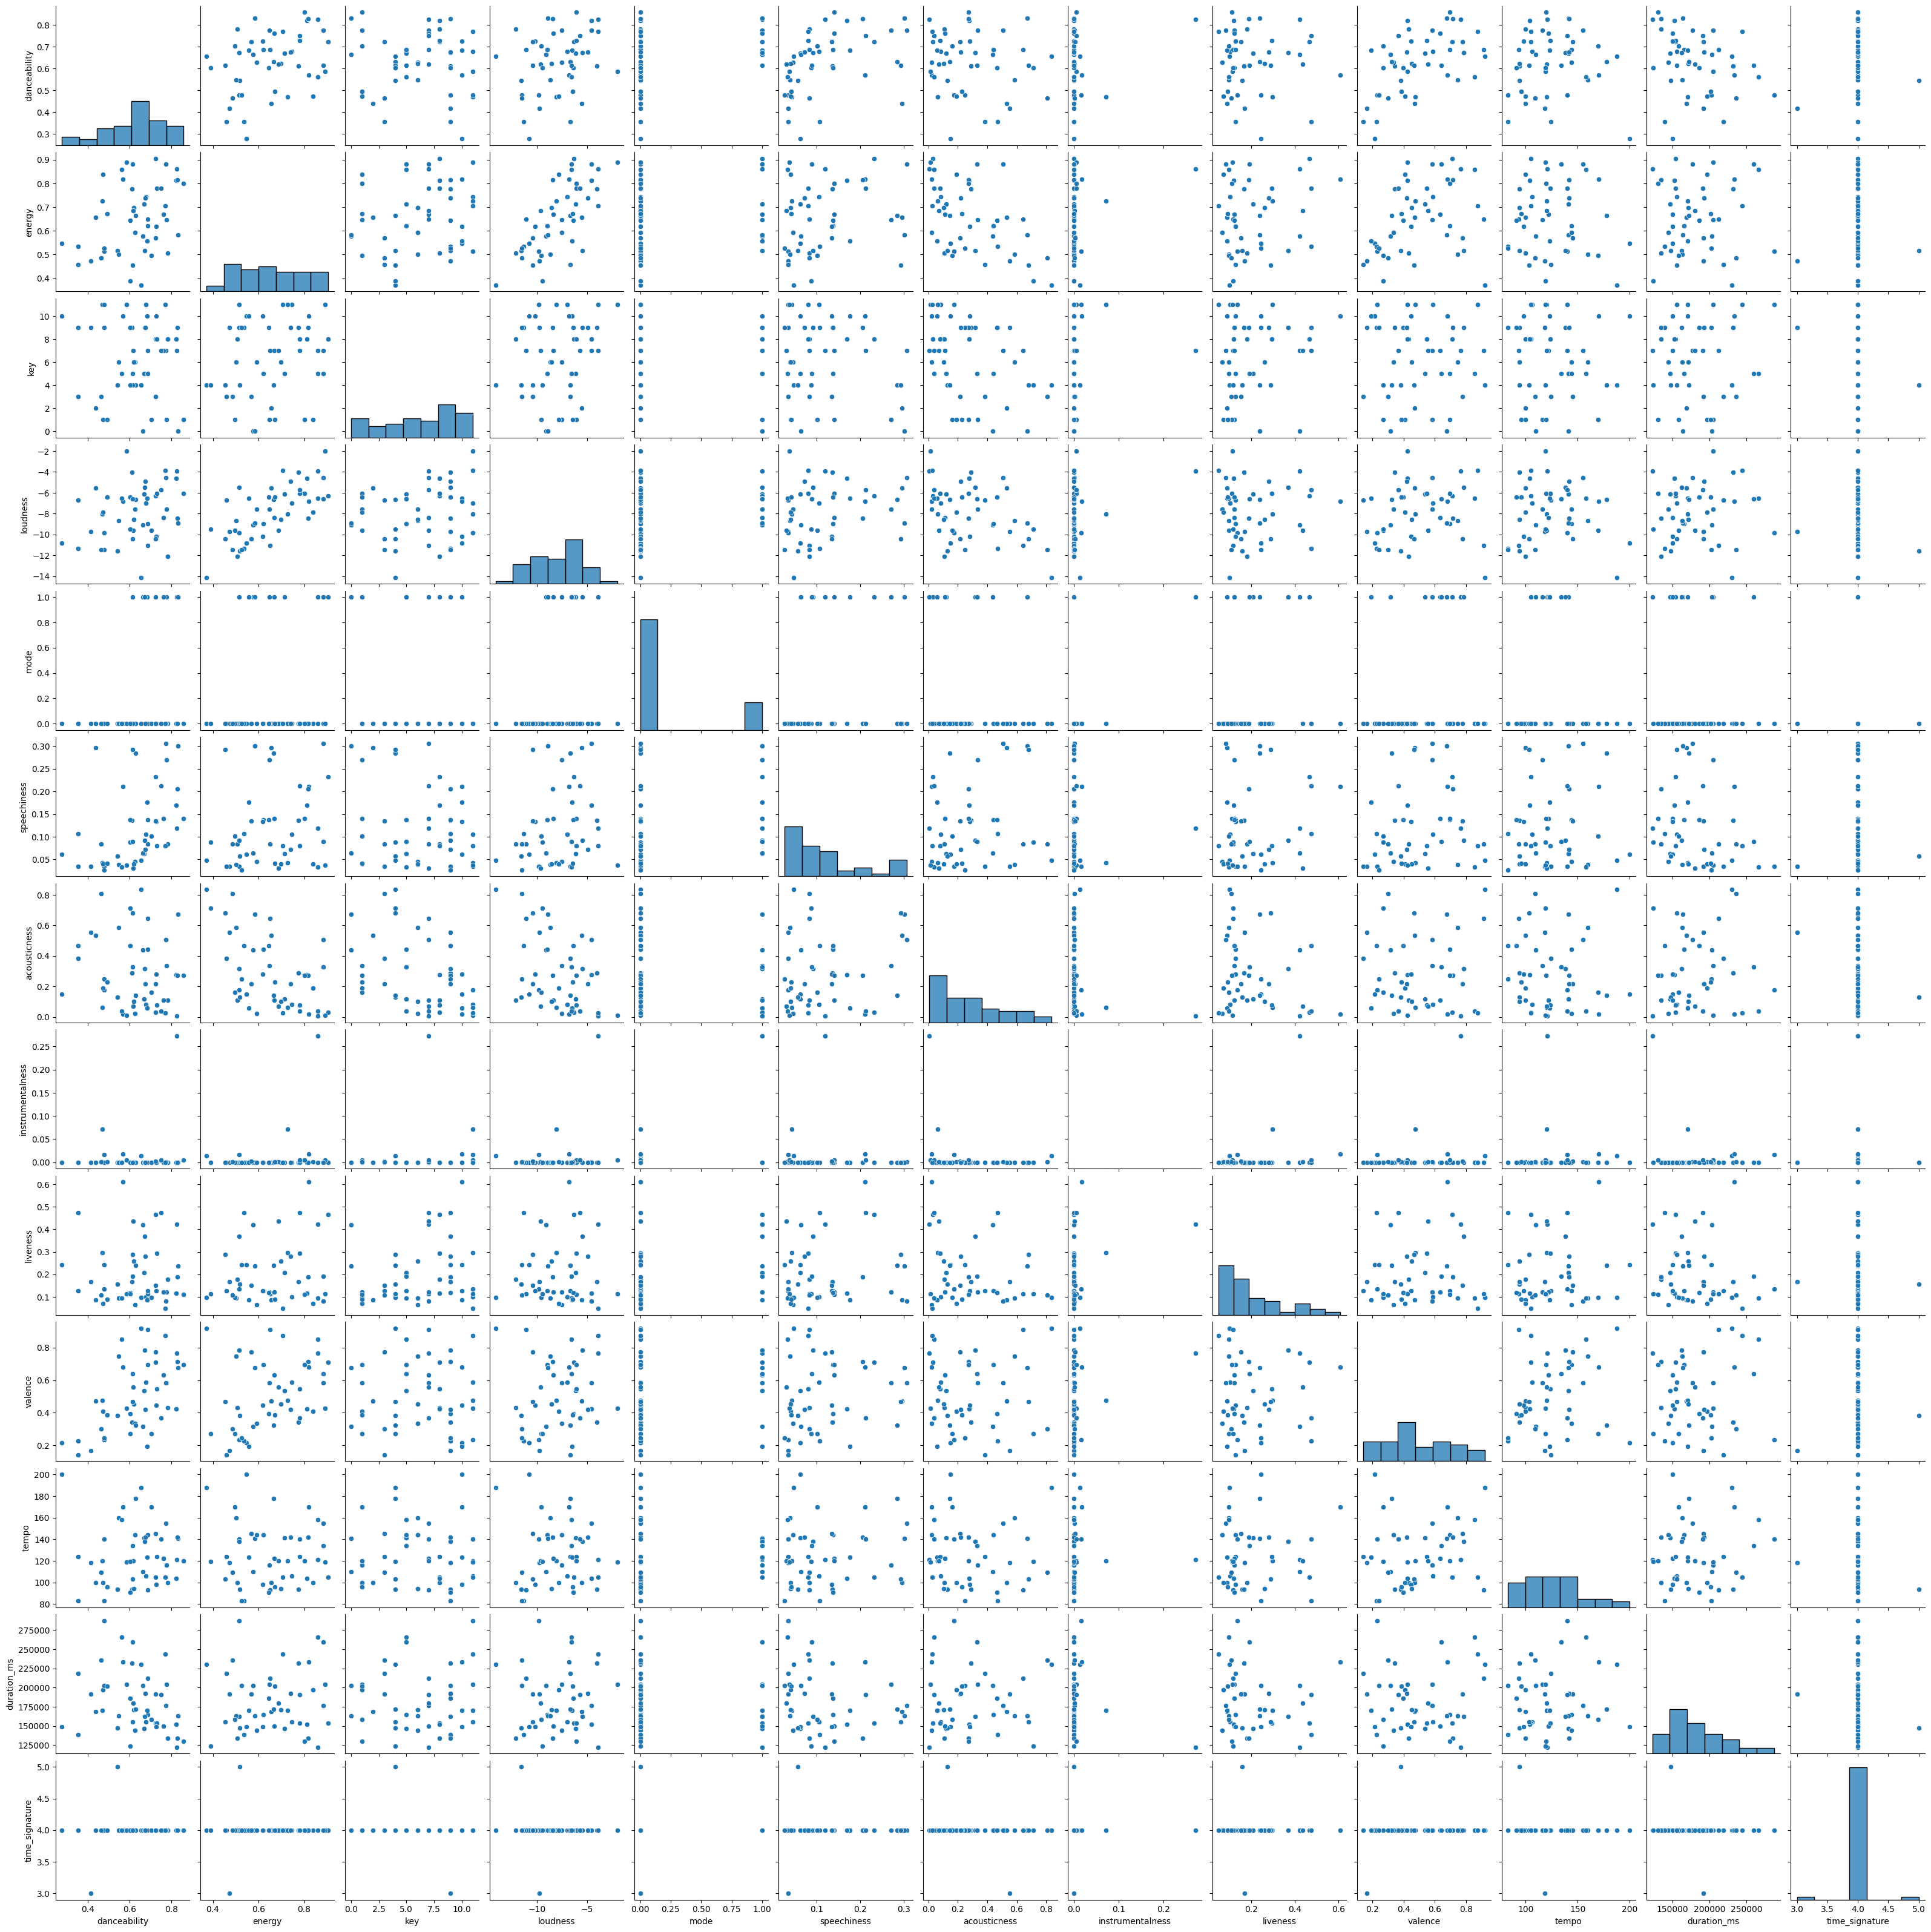

In [6]:
# Use "analyze_df" function for Turkey Top 50 Playlist
analyze_df(df_TR, country_code = "TR")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

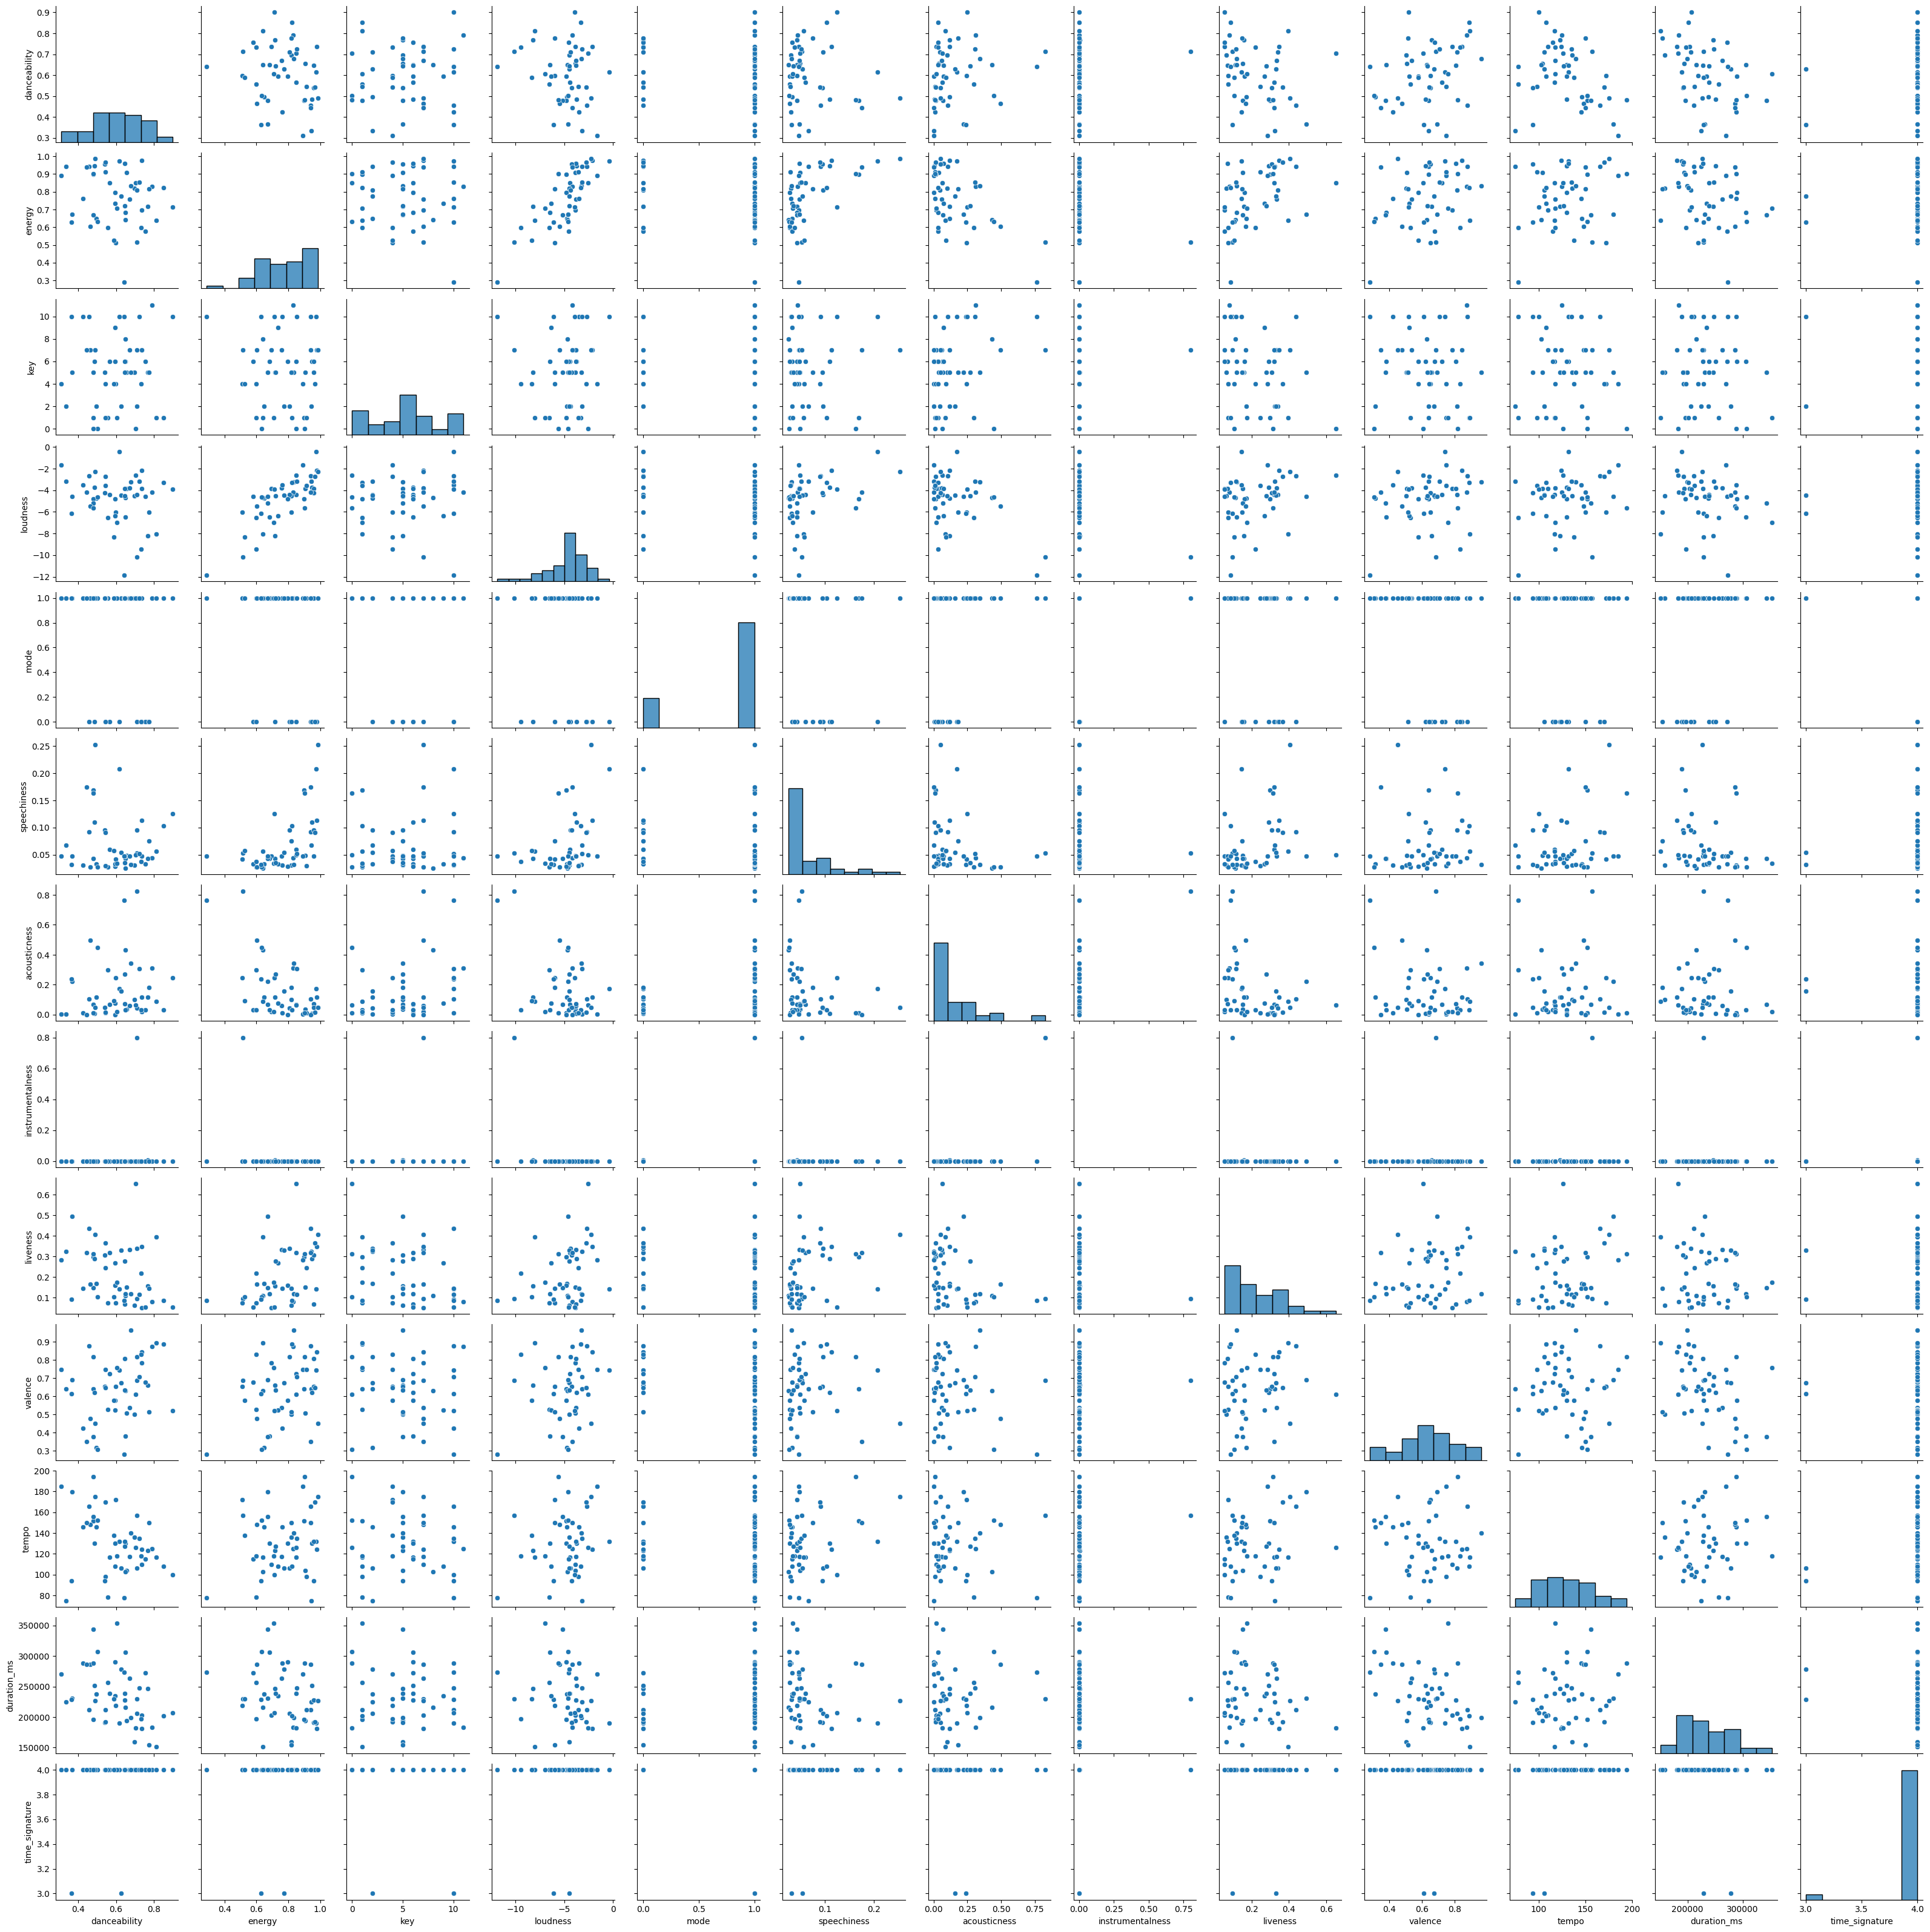

In [7]:
# Use "analyze_df" function for Japan Top 50 Playlist
analyze_df(df_JP, country_code = "JP")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

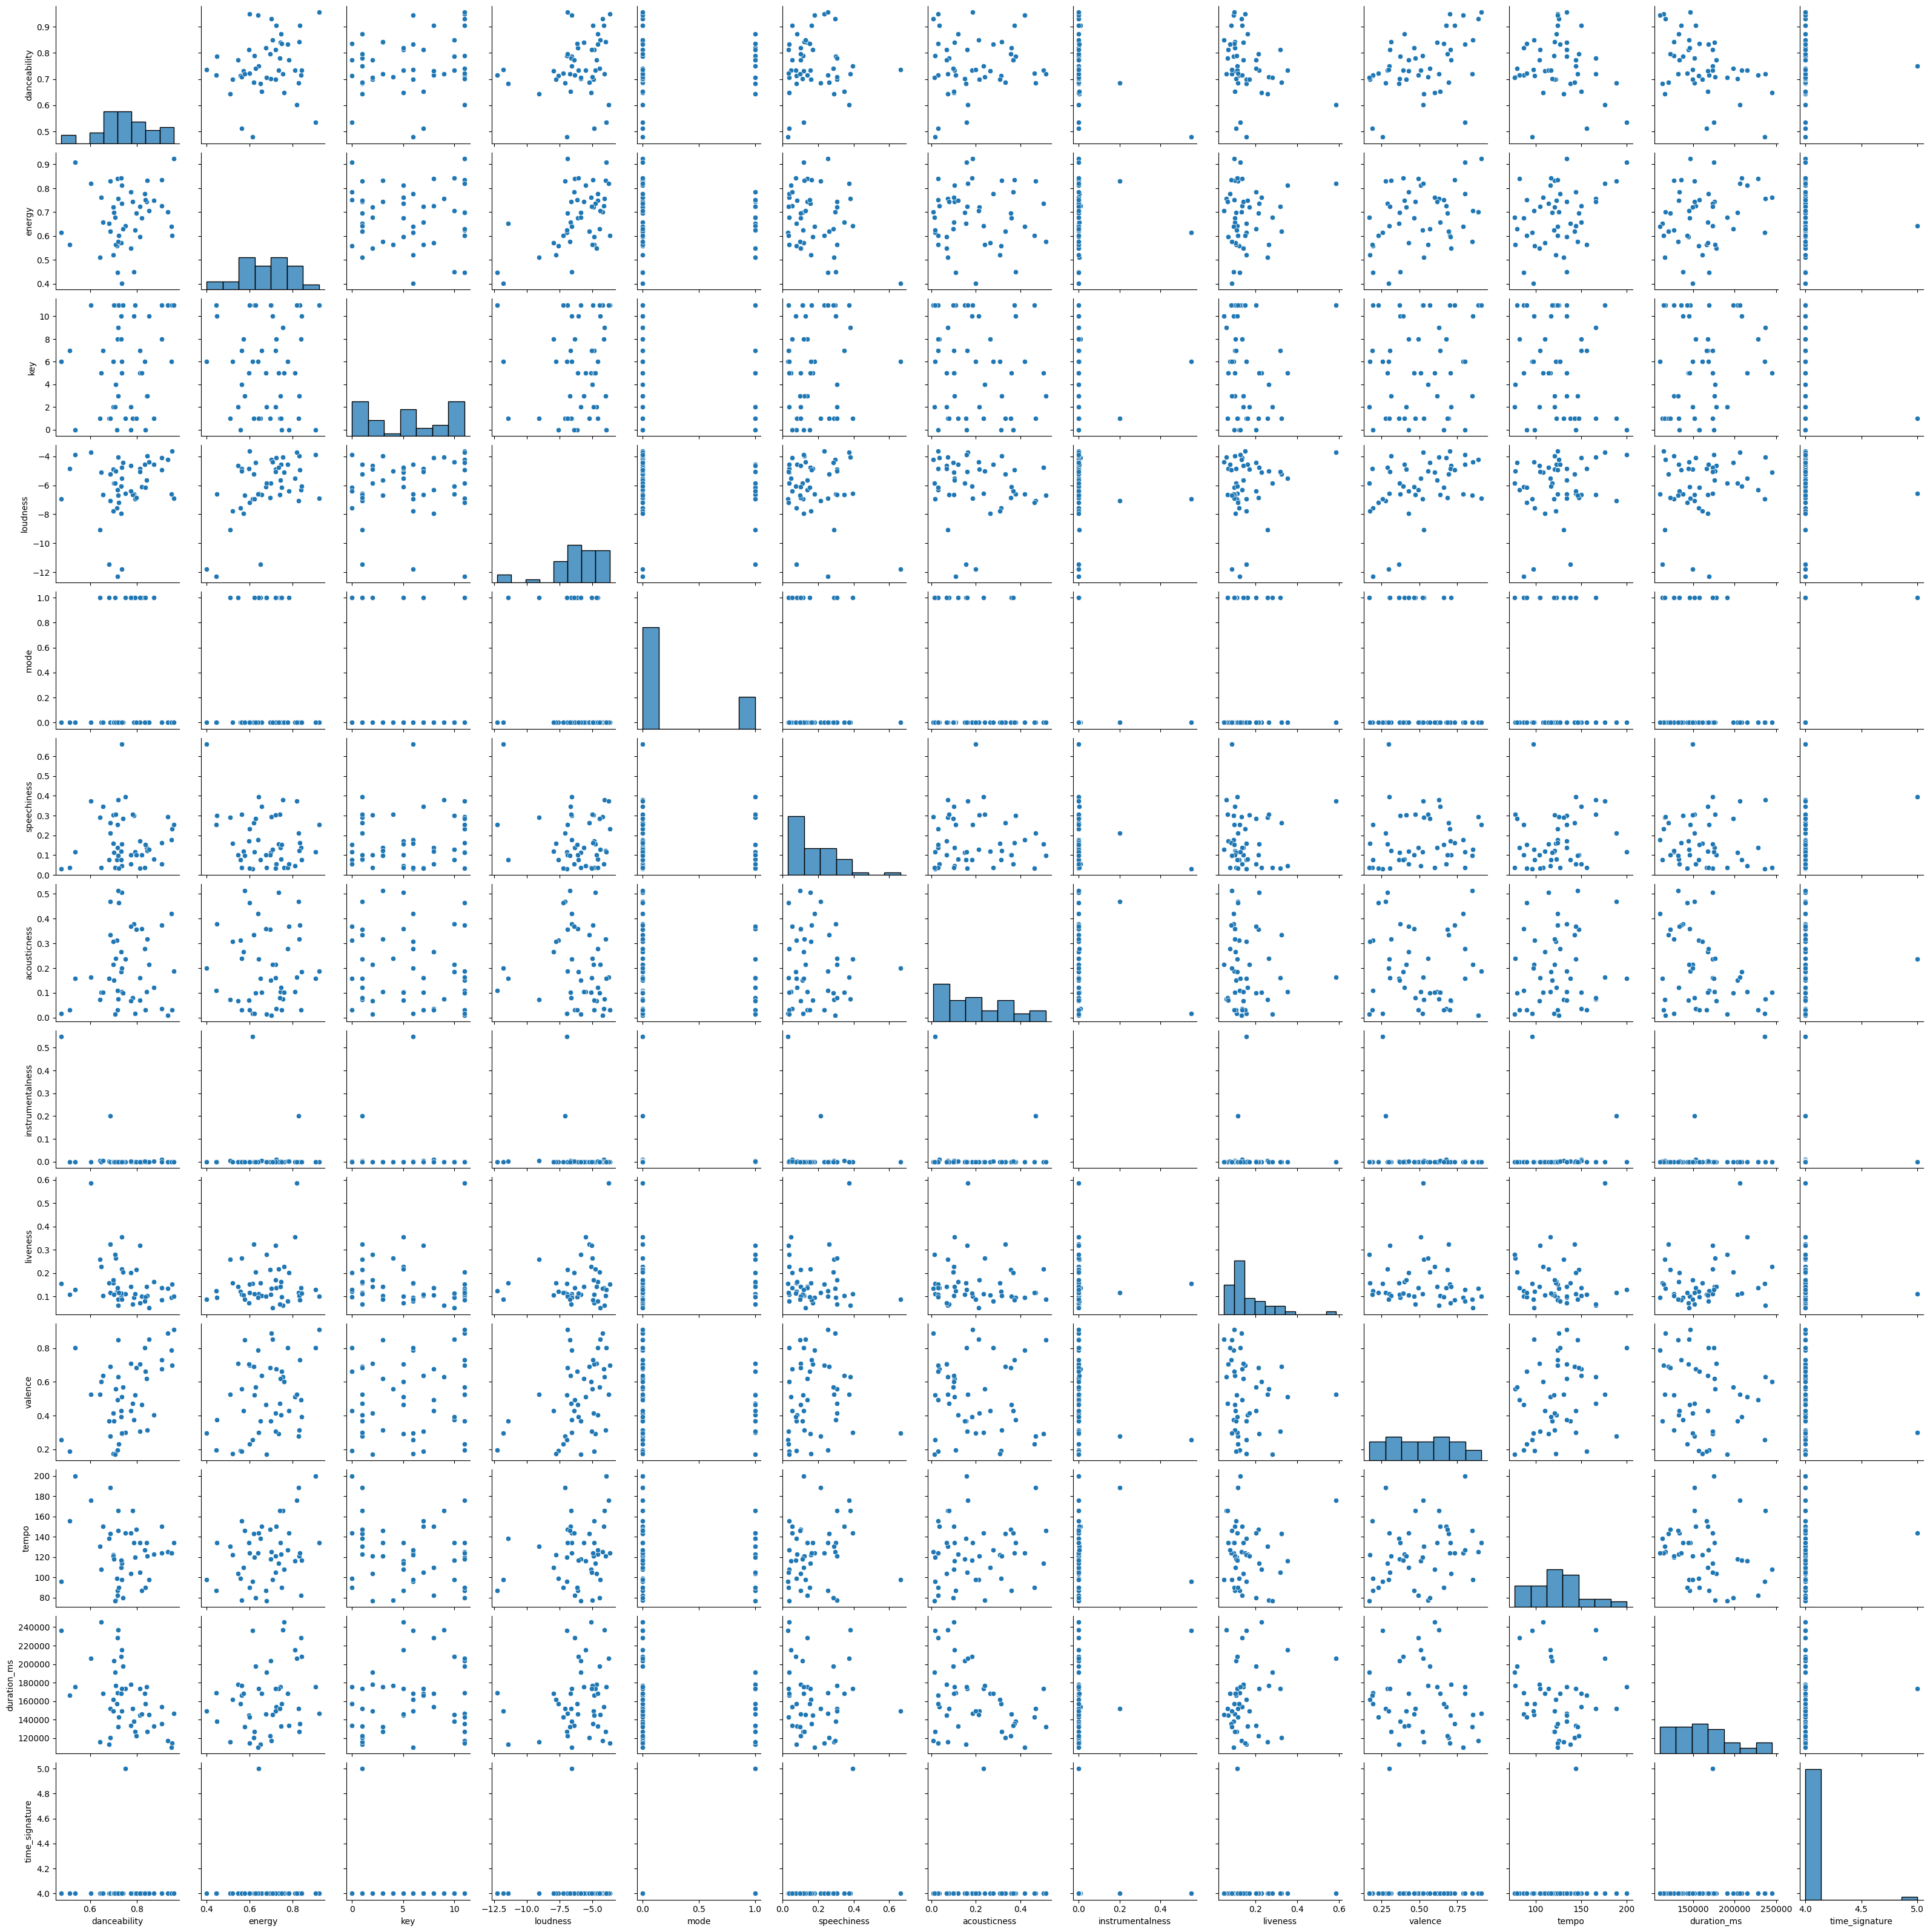

In [8]:
# Use "analyze_df" function for Russia Top 50 Playlist
analyze_df(df_RUS, country_code = "RUS")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

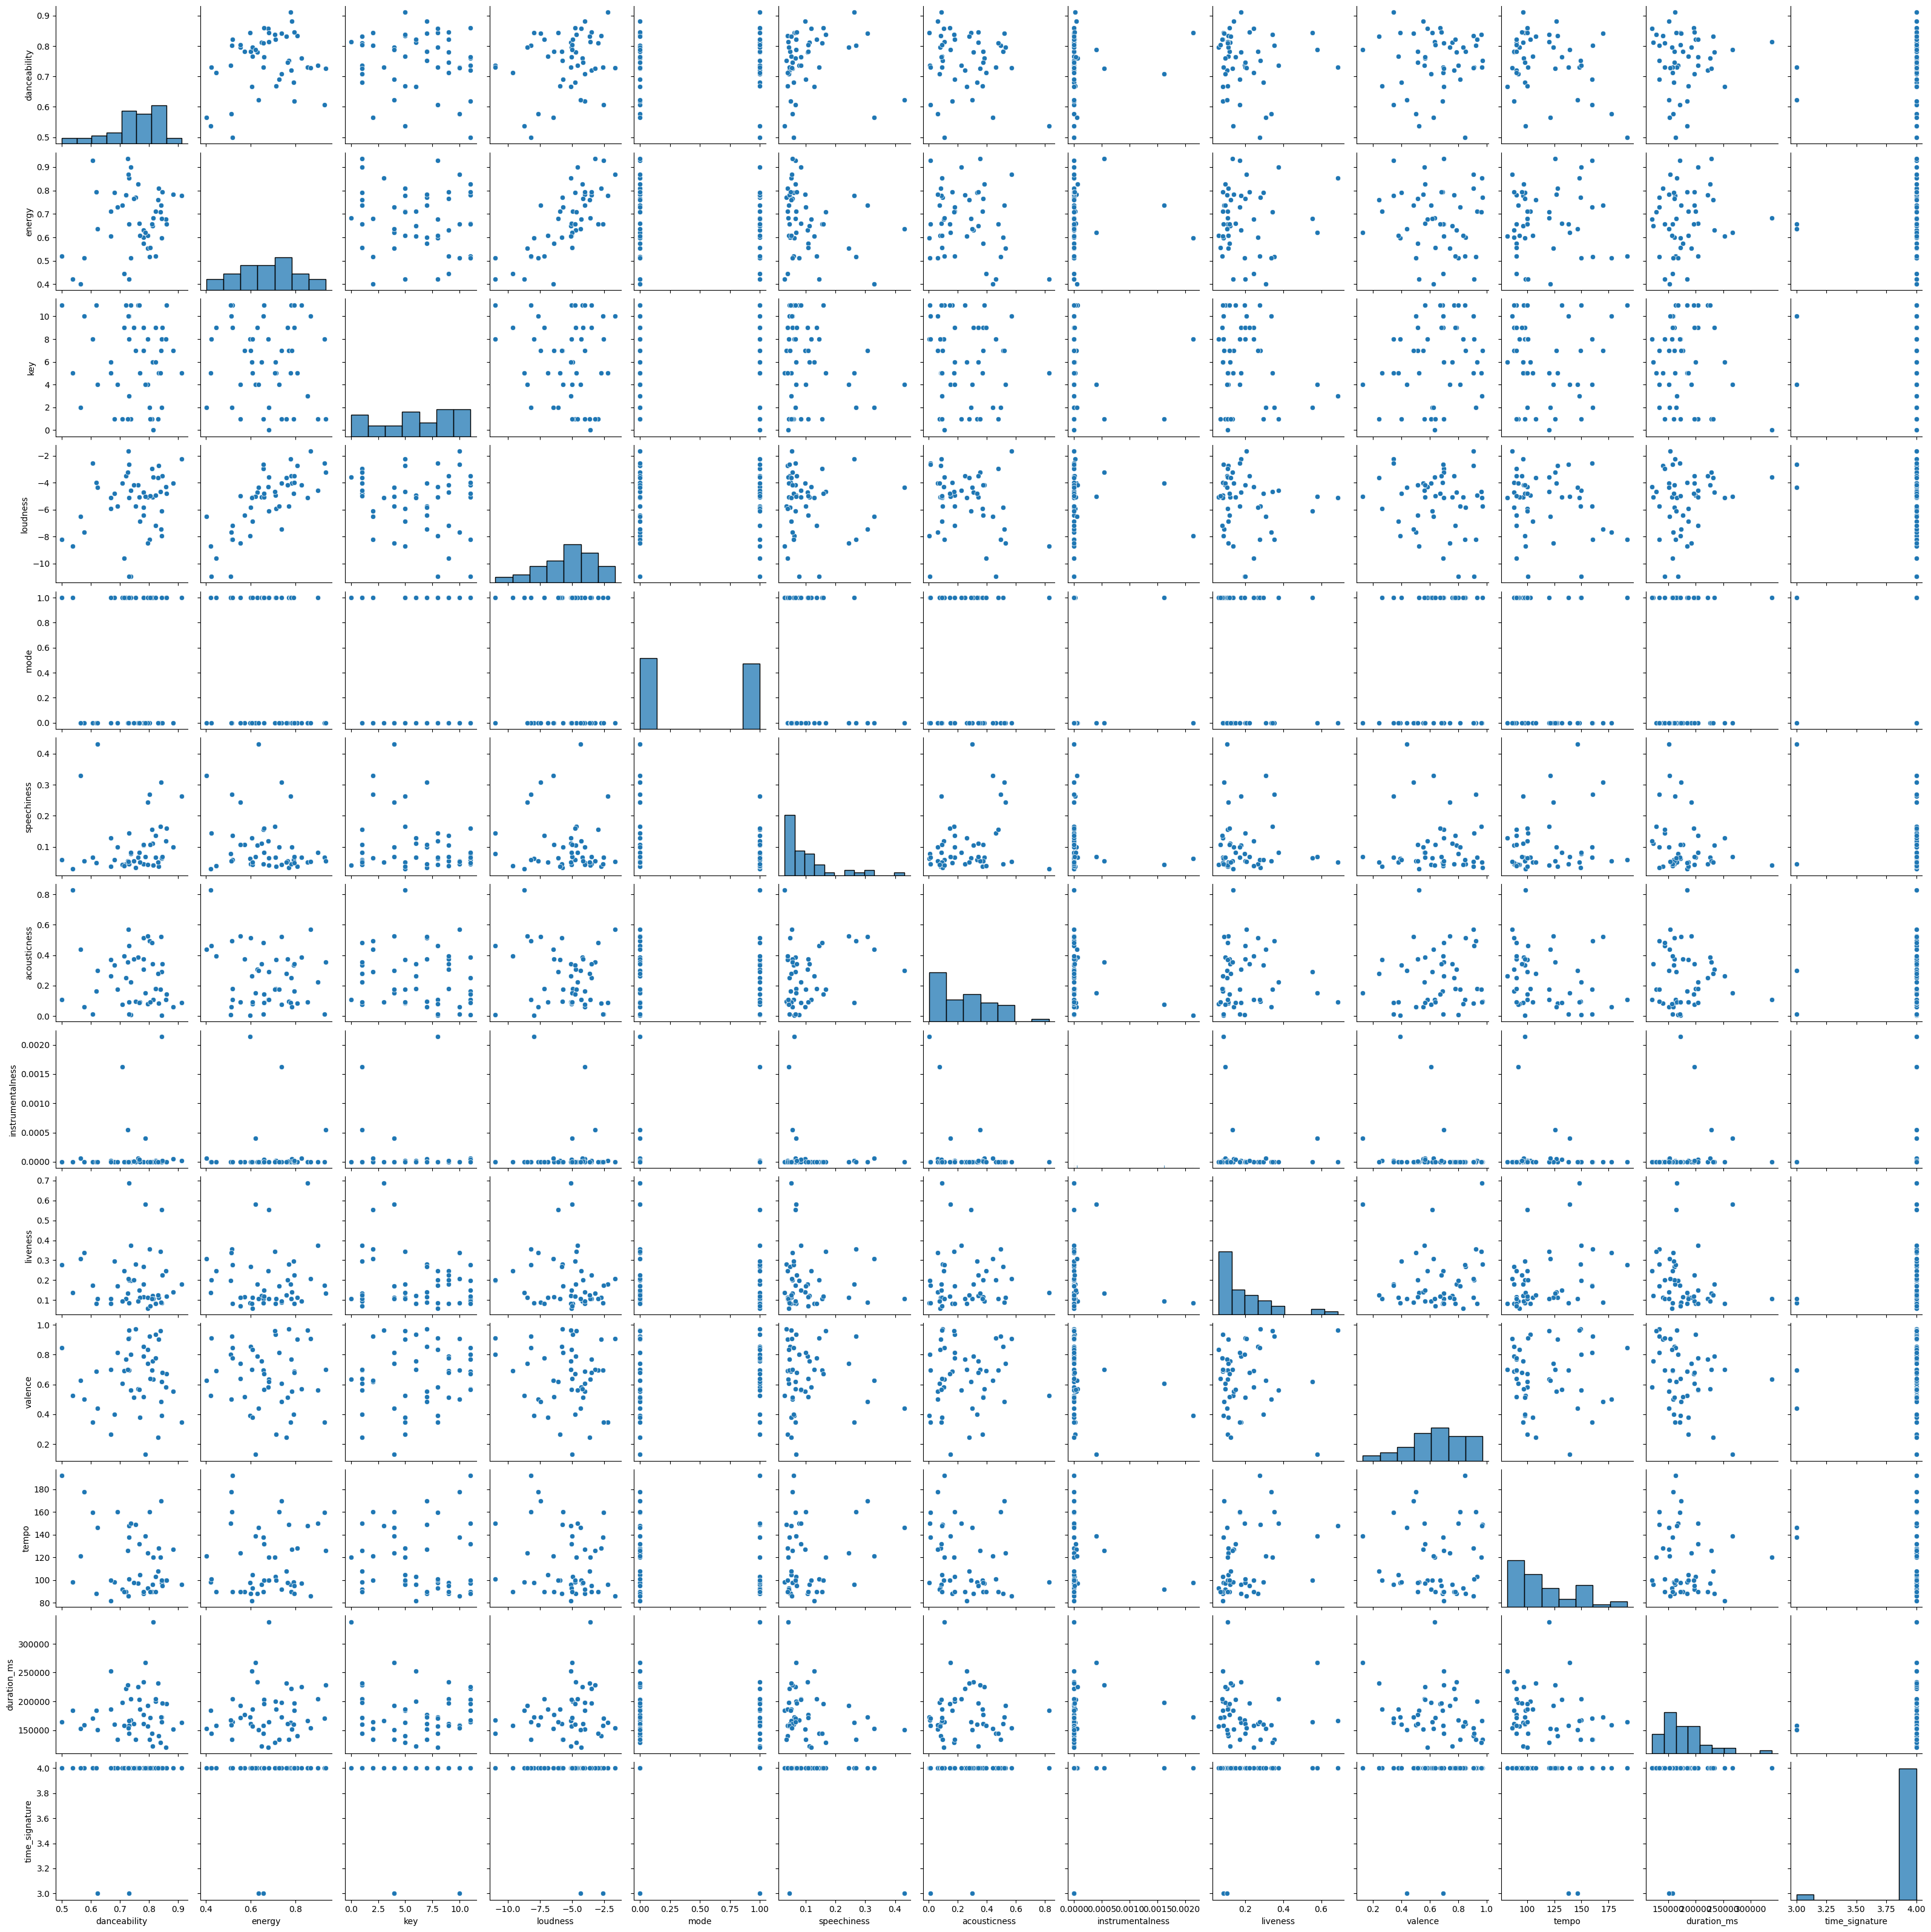

In [11]:
# Use "analyze_df" function for Argentina Top 50 Playlist
analyze_df(df_ARG, country_code = "ARG")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

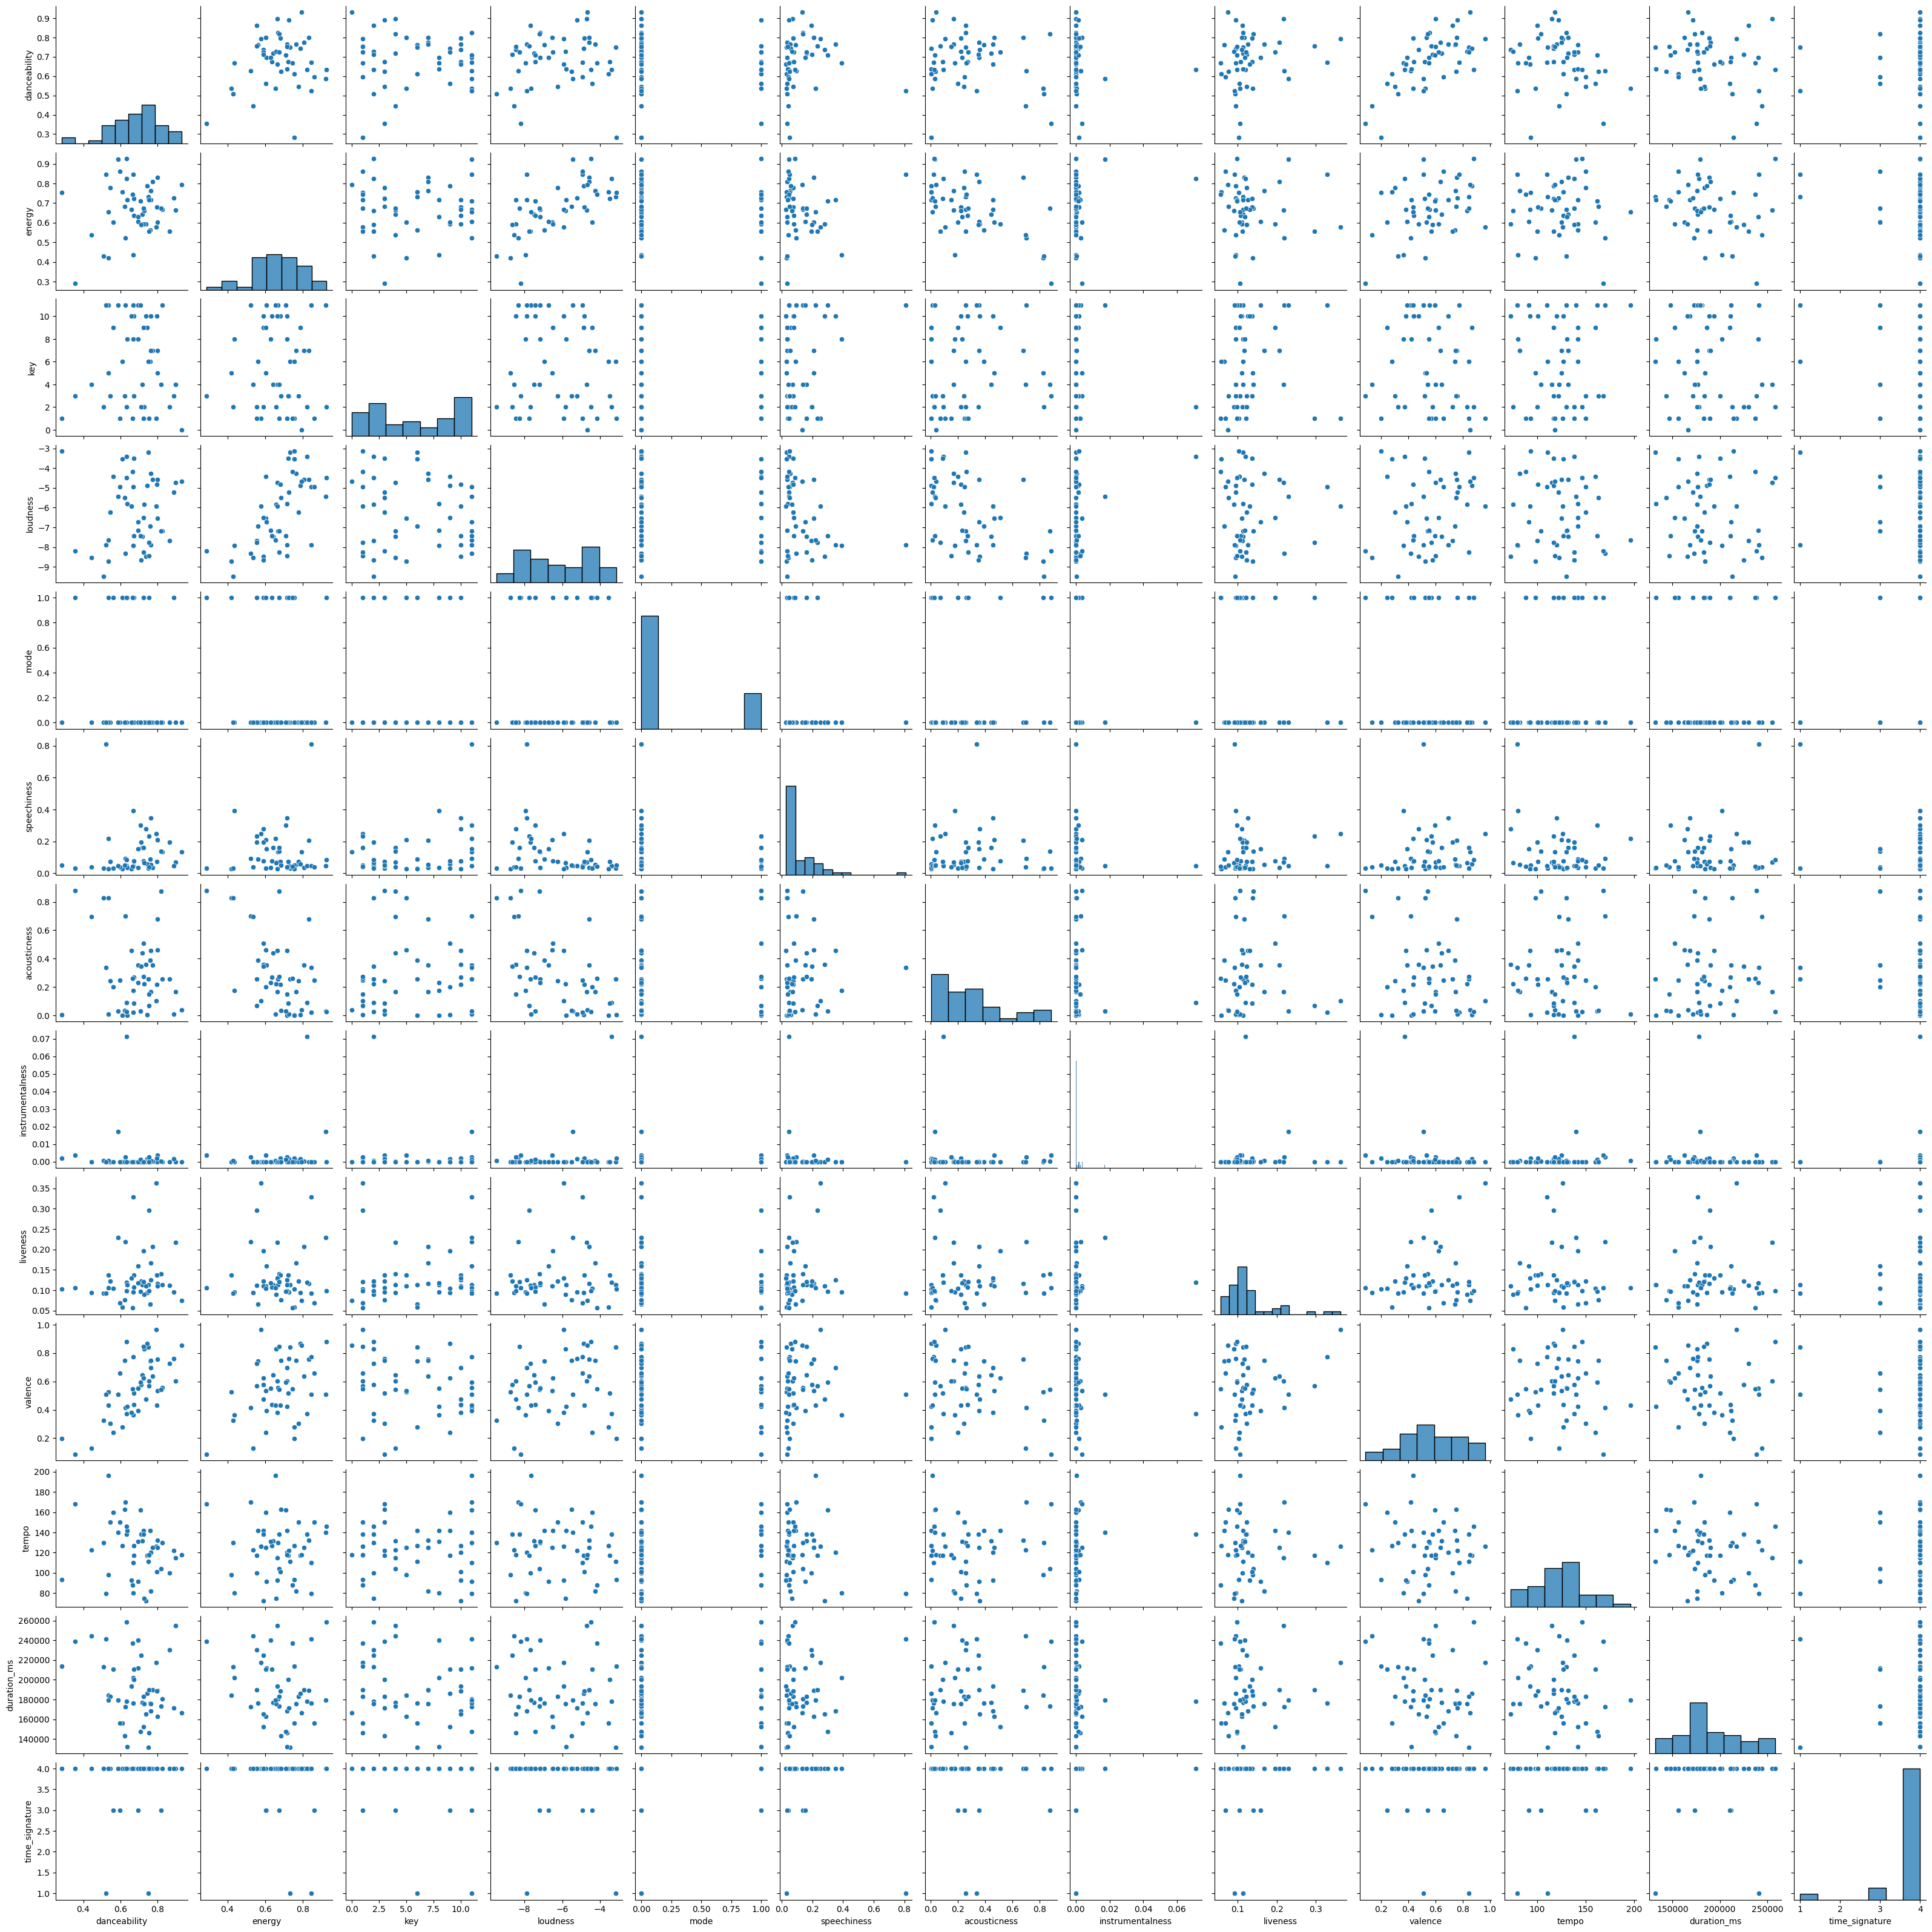

In [12]:
# Use "analyze_df" function for France Top 50 Playlist
analyze_df(df_FR, country_code = "FR")

In [13]:
# Summarize each df with a table
df_TR.describe()
df_JP.describe()
df_RUS.describe()
df_FR.describe()
df_ARG.describe() # shows only the last one 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.751460,0.672960,6.140000,-5.397140,0.480000,0.103164,0.249081,0.000100,0.194348,0.648640,115.784140,179023.760000,3.960000
std,0.091995,0.132744,3.446442,2.145386,0.504672,0.086420,0.182355,0.000383,0.135622,0.204789,28.405266,40498.578341,0.197949
min,0.499000,0.402000,0.000000,-10.957000,0.000000,0.028500,0.003620,0.000000,0.059900,0.130000,81.869000,120600.000000,3.000000
25%,0.715000,0.598750,4.000000,-6.475750,0.000000,0.050525,0.092900,0.000000,0.107250,0.518000,93.505750,154331.500000,4.000000
50%,0.766000,0.668000,6.500000,-5.000000,0.000000,0.066350,0.201500,0.000000,0.139500,0.676500,100.525000,169325.500000,4.000000
75%,0.819750,0.776000,9.000000,-4.028500,1.000000,0.116250,0.372000,0.000004,0.246750,0.798750,136.388250,197703.250000,4.000000
max,0.911000,0.936000,11.000000,-1.669000,1.000000,0.431000,0.827000,0.002140,0.688000,0.971000,192.147000,338000.000000,4.000000


# Part 3: Comparative Data Analysis

To compare the variables in different countries, since multiple groups are involved, either Kruskal-Wallis (non-parametric) or ANOVA (parametric) test will be used, depending on the normality of each variable in each group. If a variables' distribution is normal in all playlists, ANOVA will be used, else, Kruskal-Wallis will be used.

Two countries that show the most difference overall will also be compared with either a t-test (parametric) or Whitney Mann U (non-parametric) test. 

## 1. Mutliple Group Comparison - All Countries

### Statistical Tests

In [25]:
df_TR_vals = df_TR.drop(["Track_ID", "Track_Name", "Track_Artists"], axis = 1)
df_JP_vals = df_JP.drop(["Track_ID", "Track_Name", "Track_Artists"], axis = 1)
df_RUS_vals = df_RUS.drop(["Track_ID", "Track_Name", "Track_Artists"], axis = 1)
df_FR_vals = df_FR.drop(["Track_ID", "Track_Name", "Track_Artists"], axis = 1)
df_ARG_vals = df_ARG.drop(["Track_ID", "Track_Name", "Track_Artists"], axis = 1)

audio_features = df_TR_vals.columns.values # get audio feature names
write_df = pd.DataFrame(data = math.nan, columns = ["TR_Normality", "JP_Normality", "RUS_Normality", "FR_Normality", "ARG_Normality", "Test_Applied", "Test_pvalue", "Test_Result"], index = audio_features)
country_codes = ["TR", "JP", "RUS", "FR", "ARG"]

for feature in audio_features: # for each feature
	# get groups
	grp_TR = df_TR_vals[feature]
	grp_JP = df_JP_vals[feature]
	grp_RUS = df_RUS_vals[feature]
	grp_FR = df_FR_vals[feature]
	grp_ARG = df_ARG_vals[feature]

	# NORMALITY TEST: if all values in the group are the same, p-value = NULL
  	# calculate shapiro-wilk values for each group
	for country in country_codes: # for each country code
		series_country = locals()["grp_{}".format(country)] # get group series defined above
		if (len(np.unique(series_country)) > 1):
			shapiro_pval = shapiro(series_country).pvalue
			if shapiro_pval < 0.05:
				shapiro_write = "NORMAL"
			else:
				shapiro_write = "NOT_NORMAL"
		else:
			shapiro_write = "NOT_NORMAL"

		write_df.loc[feature, "{}_Normality".format(country)] = shapiro_write # write to df
	

	# Apply Kruskal-Wallis or ANOVA test
	if ("NOT_NORMAL" in write_df.loc[feature, ["TR_Normality", "JP_Normality", "RUS_Normality", "FR_Normality", "ARG_Normality"]].values): # if any of the groups is not normal
		pval = kruskal(grp_TR, grp_JP, grp_RUS, grp_FR, grp_ARG).pvalue # apply kruskal
		app_test = "Kruskal-Wallis"
	else: 
		pval = f_oneway(grp_TR, grp_JP, grp_RUS, grp_FR, grp_ARG).pvalue # apply ANOVA
		app_test = "ANOVA"
		
	write_df.loc[feature, "Test_pvalue"] = pval
	write_df.loc[feature, "Test_Applied"] = app_test

	if (pval < 0.05):
		write_df.loc[feature, "Test_Result"] = "SIGNIFICANT_DIFFERENCE"
	else: 
		write_df.loc[feature, "Test_Result"] = "NO_SIGNIFICANT_DIFF"


In [26]:
write_df

,TR_Normality,JP_Normality,RUS_Normality,FR_Normality,ARG_Normality,Test_Applied,Test_pvalue,Test_Result
danceability,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,NORMAL,Kruskal-Wallis,1.666756e-10,SIGNIFICANT_DIFFERENCE
energy,NOT_NORMAL,NORMAL,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,Kruskal-Wallis,1.104381e-03,SIGNIFICANT_DIFFERENCE
key,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,5.590954e-01,NO_SIGNIFICANT_DIFF
loudness,NOT_NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,Kruskal-Wallis,9.116639e-10,SIGNIFICANT_DIFFERENCE
mode,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,2.123789e-11,SIGNIFICANT_DIFFERENCE
speechiness,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,1.054909e-05,SIGNIFICANT_DIFFERENCE
acousticness,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,4.495789e-03,SIGNIFICANT_DIFFERENCE
instrumentalness,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,6.377999e-01,NO_SIGNIFICANT_DIFF
liveness,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,ANOVA,2.745882e-03,SIGNIFICANT_DIFFERENCE
valence,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,NOT_NORMAL,Kruskal-Wallis,4.749800e-04,SIGNIFICANT_DIFFERENCE


### Boxplots

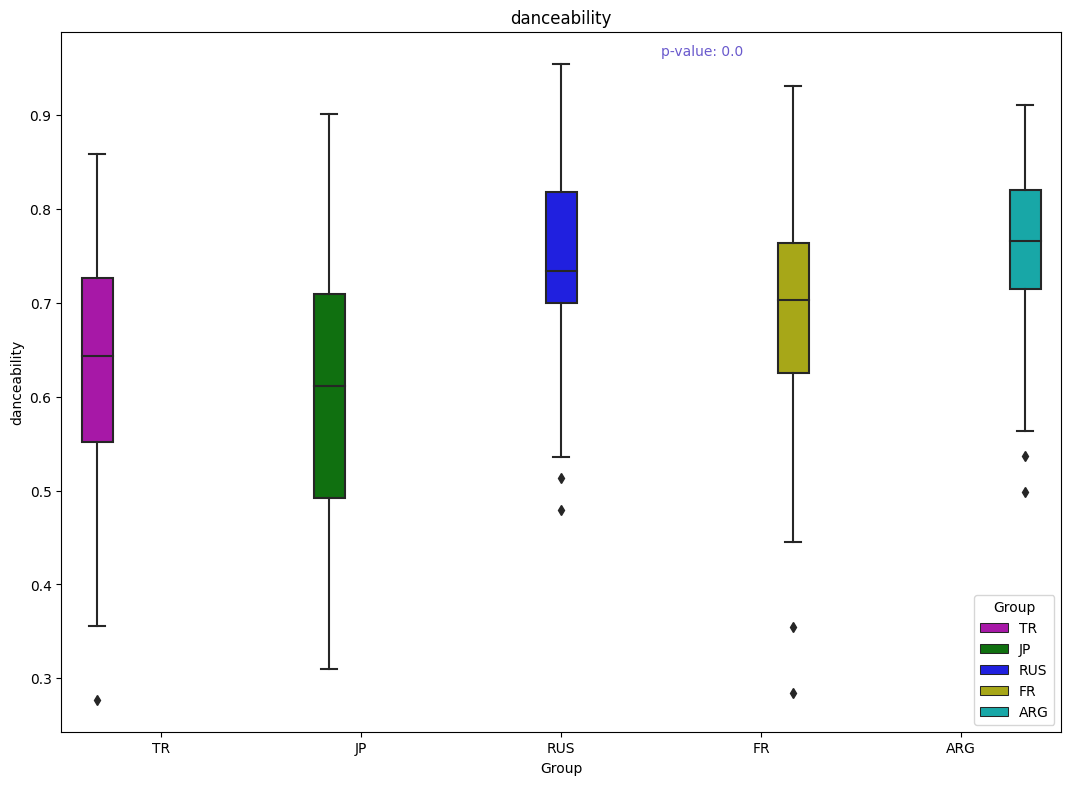

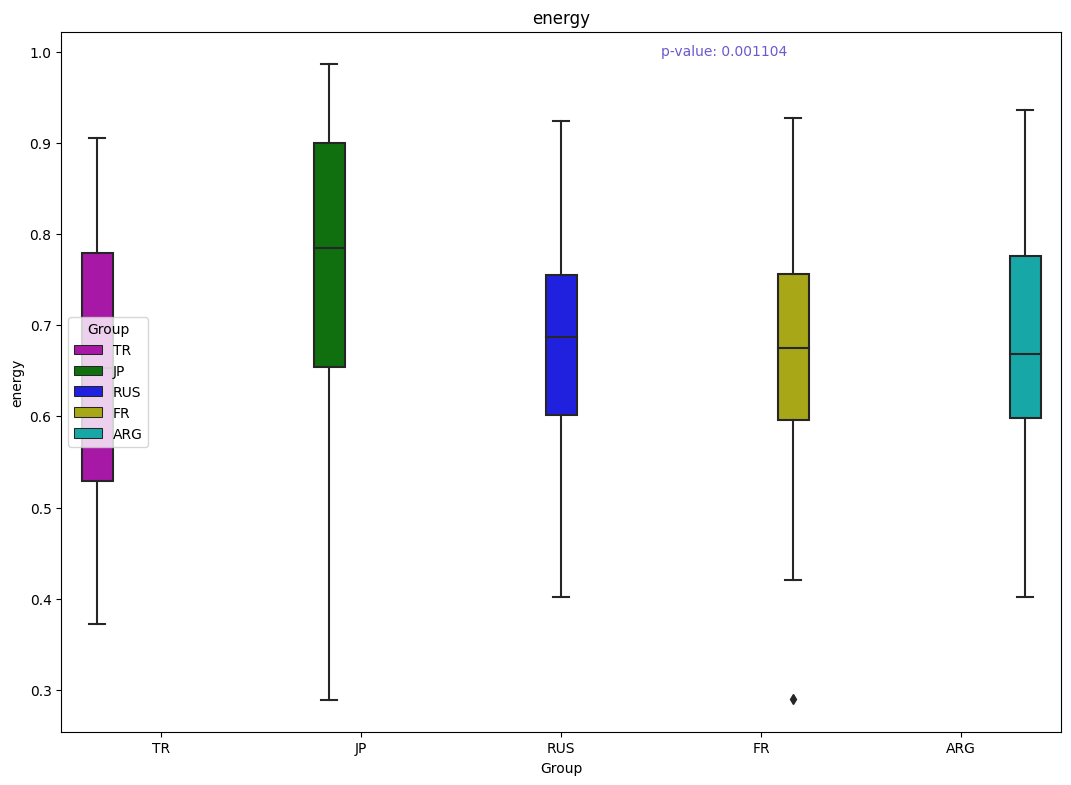

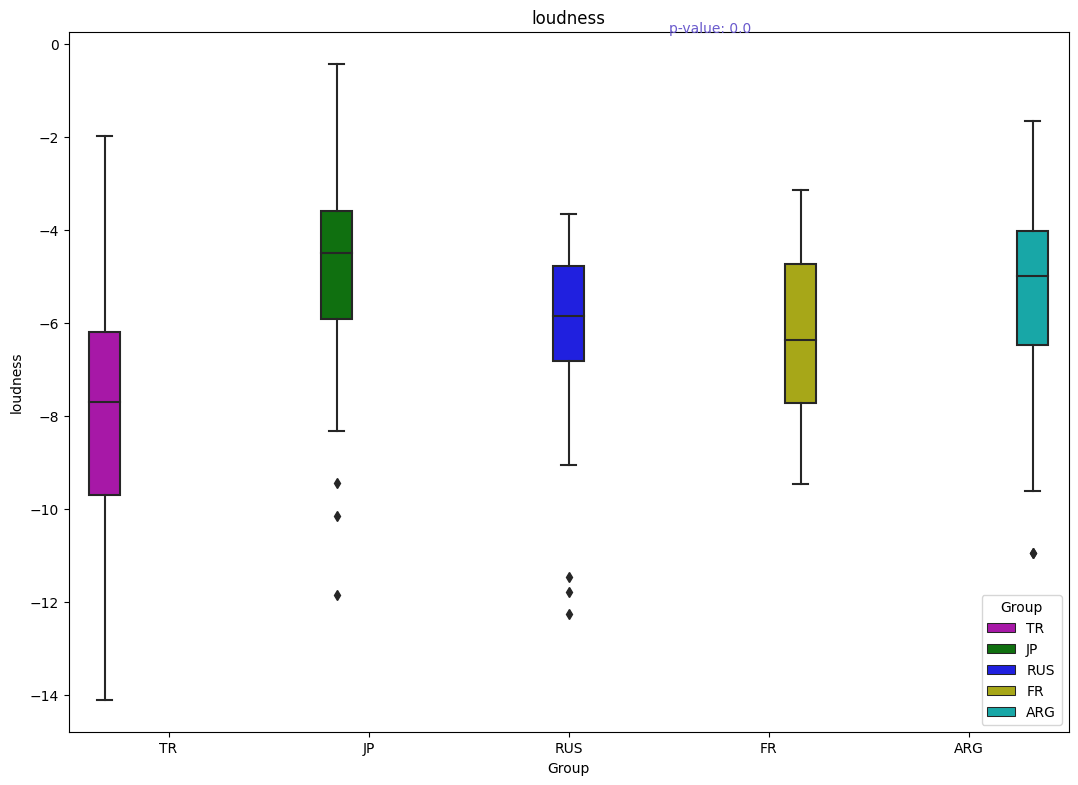

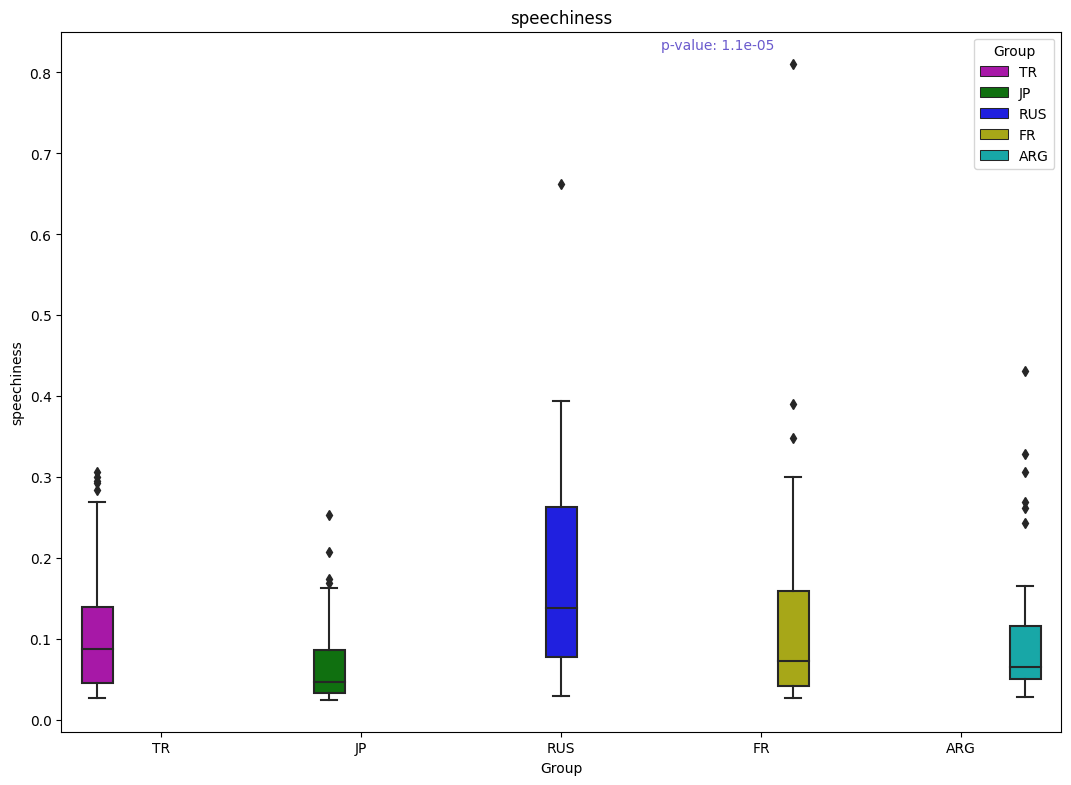

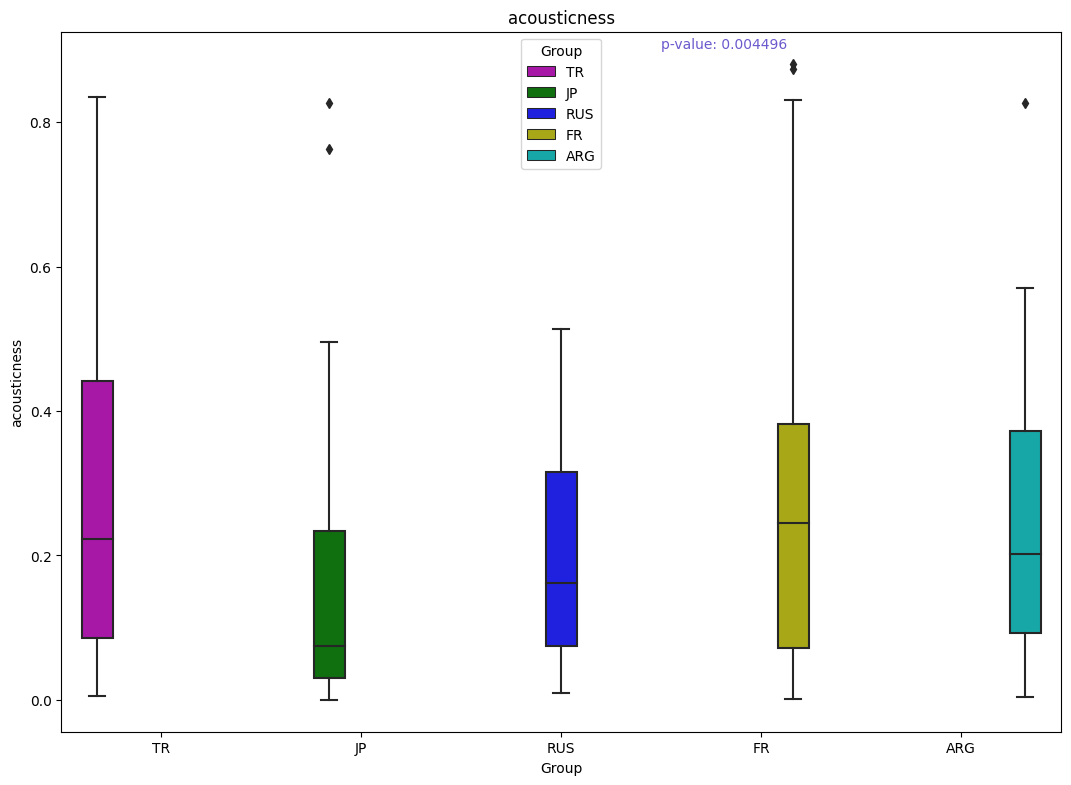

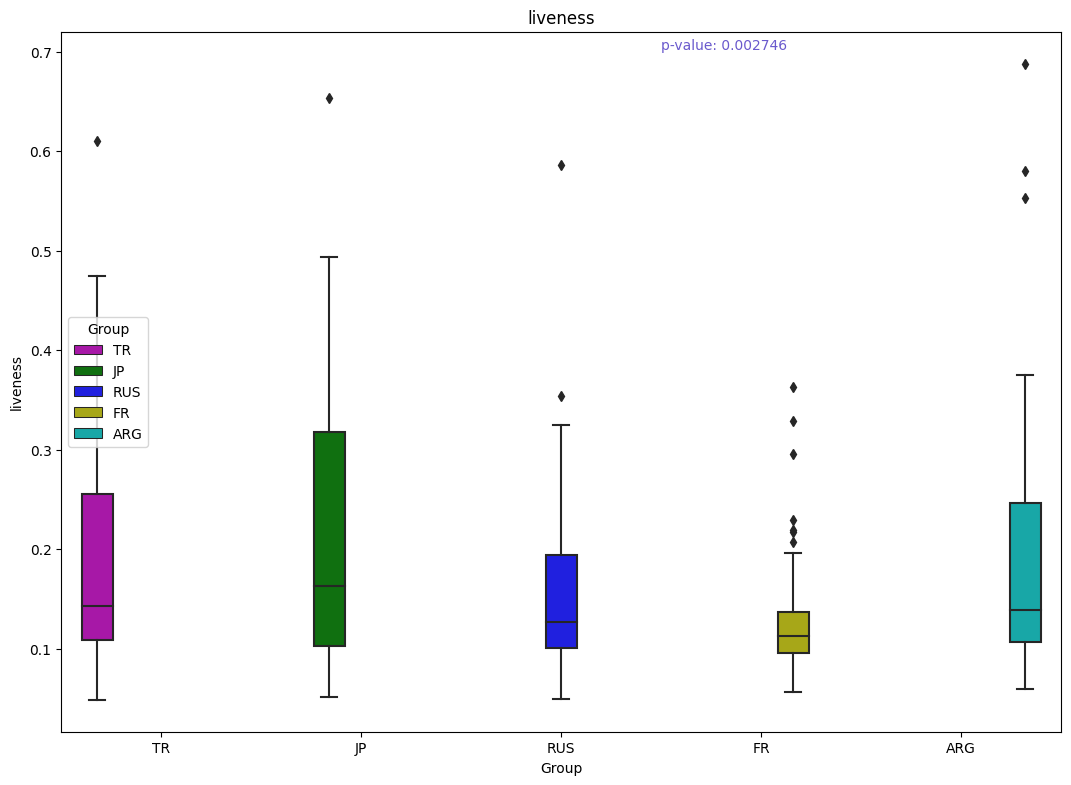

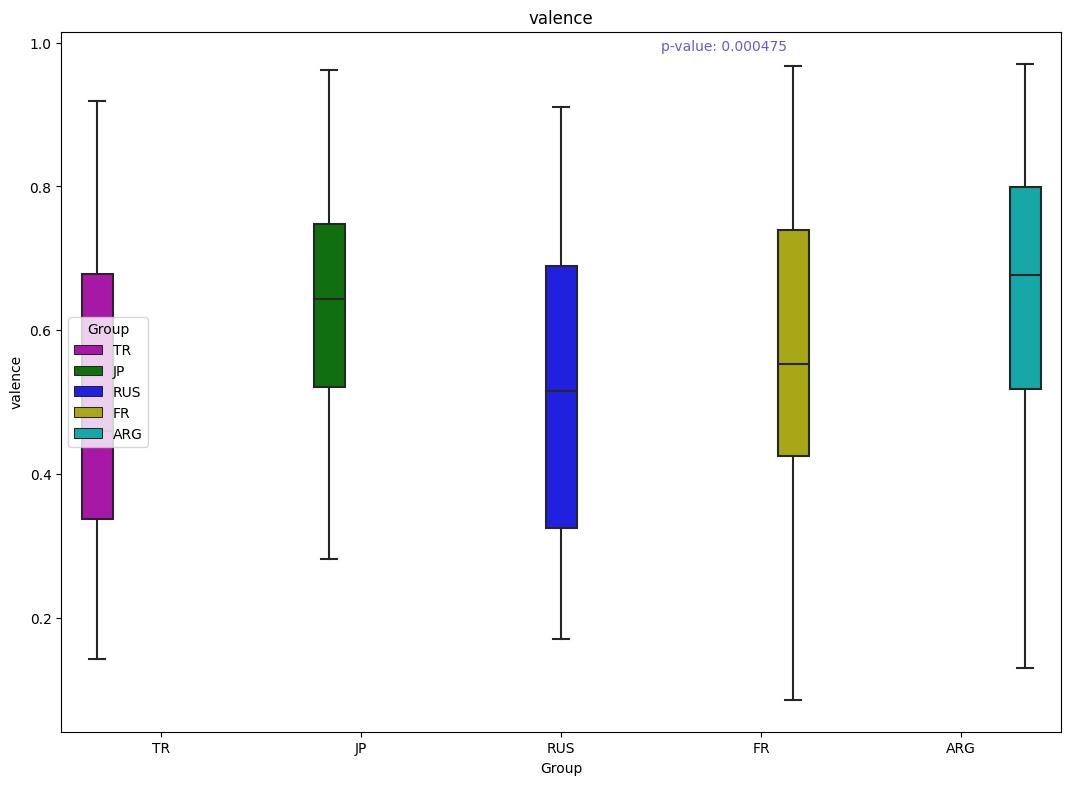

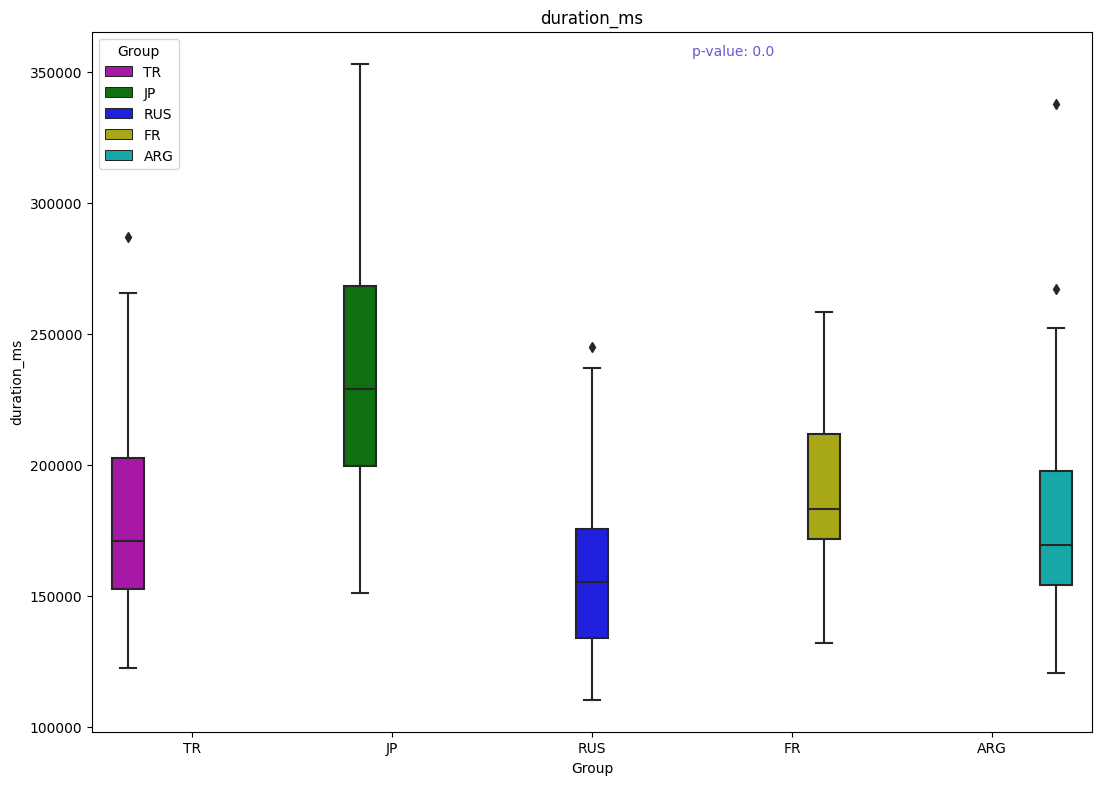

In [44]:
significant_df = write_df.loc[write_df.Test_Result == "SIGNIFICANT_DIFFERENCE"] # get only significantly different features
features_list = significant_df.drop(["time_signature", "mode"], axis = 0).index.values # remove the categorical features

for feature in features_list:
	data_TR = df_TR[feature].values.astype(float)
	data_JP = df_JP[feature].values.astype(float)
	data_RUS = df_RUS[feature].values.astype(float)
	data_FR = df_FR[feature].values.astype(float)
	data_ARG = df_ARG[feature].values.astype(float)

	data_arr = [np.concatenate((data_TR, data_JP, data_RUS, data_FR, data_ARG)), 
		np.concatenate((["TR"] * len(data_TR), ["JP"] * len(data_JP), ["RUS"] * len(data_RUS),
		["FR"] * len(data_FR), ["ARG"] * len(data_ARG)))]
	data_df = pd.DataFrame(data_arr).T
	data_df.columns = [feature, "Group"]

	pval = significant_df.at[feature, "Test_pvalue"]

	fig = plt.figure(figsize = (10, 7))
	ax = fig.add_axes([0, 0, 1, 1])

	sns.boxplot(x = "Group", y = feature,
            hue = "Group", palette = ["m", "g", "b", "y", "c"],
            data = data_df).set(title = feature)
	
	y1,y2 = plt.ylim()
	x1,x2 = plt.xlim()
	plt.text((x2-x1)/2, y2 - (y2/40), "p-value: {}".format(round(pval, 6)), color = "slateblue")

	plt.savefig("./results/{}_boxplot.png".format(feature), dpi = 200, bbox_inches = "tight")

In [ ]:
def stat_compare(group1_df, group2_df):
	bacteria_names = group1_df.columns.values
	write_df = pd.DataFrame(data = math.nan, columns = ["Group1_Normality", "Group2_Normality", "Test_Applied", "Test_pvalue", "Test_Result", "Test_Fold"], index = bacteria_names)

	for bacteria in bacteria_names:
		grp1 = group1_df[bacteria]
		grp2 = group2_df[bacteria]
		print(bacteria)
		# NORMALITY TEST: if all values in the group are same, p-value = NULL
  		# calculate shapiro-wilk values for each group
		if (len(np.unique(grp1)) > 1):
			shapiro_pval = shapiro(grp1).pvalue
			if shapiro_pval < 0.05:
				shapiro1_write = "NORMAL"
			else:
				shapiro1_write = "NOT_NORMAL"
		else:
			shapiro1_write = "NOT_NORMAL"

		write_df.loc[bacteria, "Group1_Normality"] = shapiro1_write

		if (len(np.unique(grp2)) > 1):
			shapiro_pval = shapiro(grp2).pvalue
			if shapiro_pval < 0.05:
				shapiro2_write = "NORMAL"
			else:
				shapiro2_write = "NOT_NORMAL"
		else:
			shapiro2_write = "NOT_NORMAL"
			
		write_df.loc[bacteria, "Group2_Normality"] = shapiro2_write

		# Apply t test or whitney mann u
		grp1 = group1_df[bacteria].values.astype(float)
		grp2 = group2_df[bacteria].values.astype(float)

		if (shapiro1_write == "NOT_NORMAL" or shapiro2_write == "NOT_NORMAL"):
			if (sum(grp1) == 0 or sum(grp2) == 0):
				pval = 1
				app_test = "All-zeros"
			else:
				pval = mannwhitneyu(grp1, grp2).pvalue
				app_test = "MannWhitney-U"
		else:
			if (sum(grp1) == 0 or sum(grp2) == 0):
				pval = 1
				app_test = "All-zeros"
			else:
				pval = ttest_ind(grp1, grp2, equal_var = False).pvalue
				app_test = "T-test"
		
		write_df.loc[bacteria, "Test_pvalue"] = pval
		write_df.loc[bacteria, "Test_Applied"] = app_test

		if (pval < 0.05):
			write_df.loc[bacteria, "Test_Result"] = "SIGNIFICANT_DIFFERENCE"
		else: 
			write_df.loc[bacteria, "Test_Result"] = "NO_SIGNIFICANT_DIFF"

		# Calculate fold change (if difference is significant)
		if (pval < 0.05 and app_test == "T-test"):
			fold_change = stat.mean(grp1)/stat.mean(grp2)
		elif (pval < 0.05 and app_test == "MannWhitney-U"):
			fold_change = stat.median(grp1)/stat.median(grp2)
			if (stat.median(grp1) == 0 or stat.median(grp2) == 0):
				fold_change = stat.mean(grp1)/stat.mean(grp2)
		else:
			fold_change = math.nan

		write_df.loc[bacteria, "Test_Fold"] = fold_change

	return write_df